# <center> Classification Tree </center>

Decison Tree hierarchical stuctures used for top-down partitioning of the Feature space. Decision Tree can be used for solving both Classification and Regression problems. The space is divided by a series of Decision Functions arranged serially in a hierarchical order. The objective of the division is to reduce the overall **impurity** of the data. Thereby, gradually moving towards pure data.

## Understanding Node Impurity 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

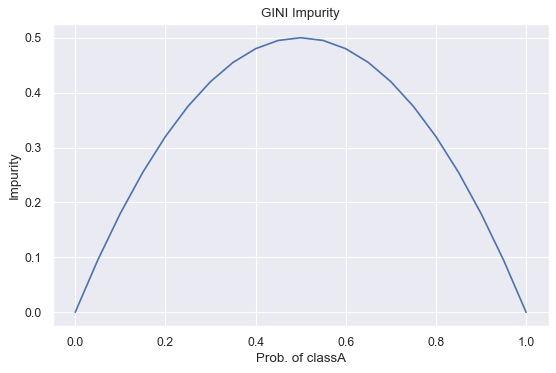

In [2]:
total = 200
classA = 0
imp_list1 = []
prob_list = []
while classA <= total:
    classB = total - classA
    label_probA = classA/total
    label_probB = classB/total
    
    imp = 1 - (label_probA**2+label_probB**2)  ### GINI Impurity
    imp_list1.append(imp)
    prob_list.append(label_probA)
    classA += 10

plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list1)
plt.title("GINI Impurity")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.show()

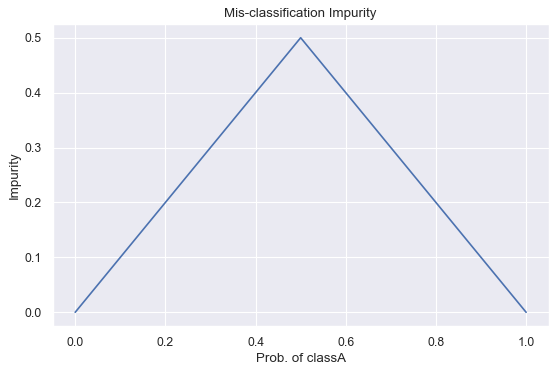

In [3]:
total = 200
classA = 0
imp_list2 = []
prob_list = []
while classA <= total:
    classB = total - classA
    label_probA = classA/total
    label_probB = classB/total
    
    imp = 1 - max(label_probA,label_probB)  ## Mis-Classification Impurity
    imp_list2.append(imp)
    prob_list.append(label_probA)
    classA += 10

plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list2)
plt.title("Mis-classification Impurity")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.show()

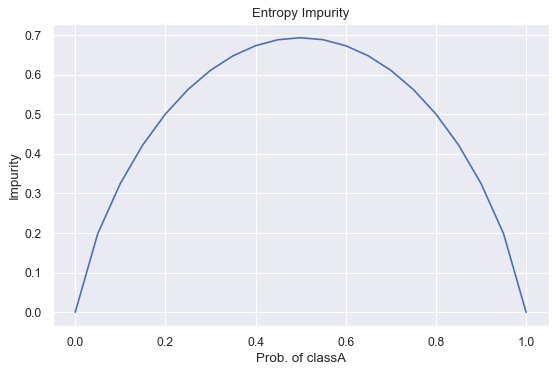

In [4]:
total = 200
classA = 0
imp_list3 = []
prob_list = []
while classA <= total:
    classB = total - classA
    label_probA = classA/total
    label_probB = classB/total
    if label_probA == 0 or label_probB == 0:  
        imp = 0                                              ## Entropy Impurity
    else:
        imp = -1*(label_probA*np.log(label_probA) + label_probB*np.log(label_probB))
    imp_list3.append(imp)
    prob_list.append(label_probA)
    classA += 10

plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list3)
plt.title("Entropy Impurity")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.show()

### Plotting it together

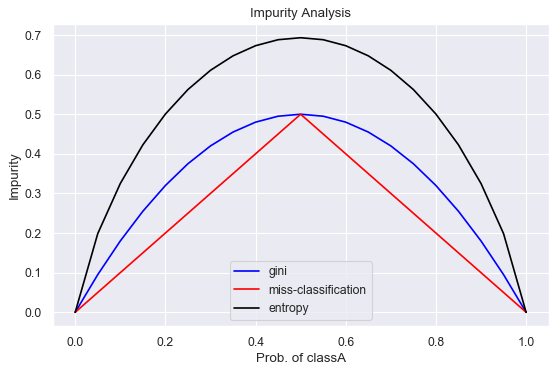

In [5]:
plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list1,c='blue',label='gini')
plt.plot(prob_list,imp_list2,c='red',label='miss-classification')
plt.plot(prob_list,imp_list3,c='black',label='entropy')
plt.title("Impurity Analysis")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.legend()
plt.show()

---

## C4.5 Decision Tree (Axis-aligned Tree)

In [16]:
import numpy as np
import pandas as pd
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

class C_Node:
    def __init__(self):
        self.m_NodeIndx = -1
        self.m_Impurity = -1
        self.m_NodeDepth = -1
        self.m_ParentNodeIndx = -1
        self.m_LeftChildIndx = -1
        self.m_RightChildIndx = -1
        self.m_IsDecisionNode = None
        self.m_Params = None
        self.m_Label = -1
        
    def setNode(self,nodeIndx,nodeDepth,parentNodeIndx):  
        self.m_NodeIndx = nodeIndx
        self.m_NodeDepth = nodeDepth
        self.m_ParentNodeIndx = parentNodeIndx 

class C_Tree:
 
    def __init__(self,maxDepth,maxNodeNum,path,dataNumThresh,impThresh,ImpDropThresh,method):
        
        self.m_MaxDepth = maxDepth
        self.m_MaxNodeNum = maxNodeNum
        self.m_CurrNodeNum = 0 
        self.m_NodeArray = [C_Node() for i in range(self.m_MaxNodeNum)]
        self.m_Path = path
        self.m_DataNumThresh = dataNumThresh
        self.m_ImpThresh = impThresh
        self.m_ImpDropThresh = ImpDropThresh
        self.m_Method = method

    def getImpurity(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        if (len(datalist.shape) == 1):
            return 0
        else:
            y = np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            label_prob = label_count/np.sum(label_count,dtype=np.float64)

            if self.m_Method == 'misclassification':                         ##Mis-classification Impurity
                if len(label_prob) == 1:
                    imp = 0
                else:
                    imp = 1 - max(label_prob)

            if self.m_Method == 'gini':                                        ##Gini Impurity
                imp = 1 - (np.sum(label_prob**2)) 

            if self.m_Method == 'entropy':                                     ##Entropy Impurity
                imp = -1 * np.sum(np.array([p*np.log(p) for p in label_prob]))
            return(imp)
        
    def infoGain(self,data_left,data_right,curr_imp):    
        filename1 = "LeftFile.csv"
        filename2 = "RightFile.csv"
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")
        imp_left = self.getImpurity(filename1)
        imp_right = self.getImpurity(filename2)
        l = len(data_left)
        r = len(data_right)
        totalImp = (l*imp_left + r*imp_right)/(l+r)
        return (curr_imp - totalImp)      
        
    def splitDataFile(self,node,filename,params):
        rows = np.genfromtxt(filename,delimiter=',')
        data_left,data_right = self.partition(rows,params)
        filename1 = self.m_Path+"/"+"d_"+str(node.m_LeftChildIndx)+".csv"
        filename2 = self.m_Path+"/"+"d_"+str(node.m_RightChildIndx)+".csv"
        os.makedirs(os.path.dirname(filename1), exist_ok=True)
        os.makedirs(os.path.dirname(filename2), exist_ok=True)
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")
        
    class Params:

        def __init__(self, dim, theta):
            self.dim = dim
            self.theta = theta

        def match(self, example):
            # Compare the feature value in an example to the
            # feature value in this question.
            val = example[self.dim]
            return val >= self.theta
    
    def partition(self,rows, params):
        true_rows, false_rows = [], []
        for row in rows:
            if params.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_split(self,filename):
        """Find the best question to ask by iterating over every feature / value
        and calculating the information gain."""
        best_gain = 0  # keep track of the best information gain
        best_params = None  # keep train of the feature / value that produced it
        current_uncertainty = self.getImpurity(filename)
        rows = np.genfromtxt(filename,delimiter=',')
        n_features = len(rows[0]) - 1  # number of columns

        for col in range(n_features):  # for each feature

            values = set([row[col] for row in rows])  # unique values in the column

            for val in values:  # for each value

                question = self.Params(col, val)

                # try splitting the dataset
                true_rows, false_rows = self.partition(rows, question)

                # Skip this split if it doesn't divide the
                # dataset.
                if len(true_rows) == 0 or len(false_rows) == 0:
                    continue

                # Calculate the information gain from this split
                gain = self.infoGain(true_rows, false_rows, current_uncertainty)

                # You actually can use '>' instead of '>=' here
                if gain >= best_gain:
                    best_gain, best_params = gain, question

        return best_gain, best_params, current_uncertainty
    
    def checkTerminationCondition(self,node,filename):
        datalist = np.genfromtxt(filename, delimiter=',')
        if len(datalist.shape) == 1:
            IsDecisionNode = False
            dataLength = 1
            Label = datalist[-1]
            imp = 0
            return IsDecisionNode,dataLength,Label,0,None 
        else:    
            dataLength = datalist.shape[0]    
            x = datalist[:,:datalist.shape[1]-1]
            y = np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            best_gain,best_params,imp = self.find_best_split(filename)
            
            if (dataLength <= self.m_DataNumThresh or imp <= self.m_ImpThresh or
                            best_gain < self.m_ImpDropThresh or node.m_NodeDepth >= self.m_MaxDepth):
                
                IsDecisionNode = False
                Label = label[np.argmax(label_count)]
            
            else: 
                IsDecisionNode = True
                Label = None
                    
            return IsDecisionNode,dataLength,Label,imp,best_params
        
    def printNodeData(self,node):
        print(str(node.m_NodeIndx)+"-----node index")
        print(str(node.m_Label)+"-------node Label")
        print(str(node.m_NodeDepth)+"------node Depth")
        print(str(node.m_DataLength)+"----- no. of datapoints")
        print(str(node.m_Impurity)+"-------- Impurity")
        if node.m_Label != None:
            print("This is a Leaf Node!")
        else:
            print("This is a Decision Node!")
        print("-------------------------")
        
    def fit(self,X_train,y_train):
        train_data = np.hstack((X_train,np.matrix(y_train).T))
        fileName = self.m_Path+"/"+"d_0.csv"
        train_data = pd.DataFrame(train_data)
        train_data.to_csv(fileName,index=False,header=False )
        
        self.m_NodeArray[0].setNode(0,0,-1)
        self.m_CurrNodeNum = self.m_CurrNodeNum+1

        for nodeCount in range(self.m_MaxNodeNum): 

            if (self.m_NodeArray[nodeCount].m_NodeIndx == nodeCount and 
                self.m_NodeArray[nodeCount].m_LeftChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_RightChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_NodeDepth >= 0):  

                dataFileName = self.m_Path+"/"+"d_"+str(self.m_NodeArray[nodeCount].m_NodeIndx)+".csv" 

                isDecisionNode,dataLength,label,impurity,params = self.checkTerminationCondition(self.m_NodeArray[nodeCount],dataFileName)
                
                self.m_NodeArray[nodeCount].m_DataLength = dataLength
                self.m_NodeArray[nodeCount].m_Impurity = impurity
                self.m_NodeArray[nodeCount].m_Label = label
                self.m_NodeArray[nodeCount].m_Params = params
                if isDecisionNode == False:
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = False
                    
                    
                if isDecisionNode == True:
                    print("j = ",params.dim)
                    print("theta = ",params.theta)
                    lci = self.m_CurrNodeNum
                    rci = self.m_CurrNodeNum+1
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = True
                    self.m_NodeArray[nodeCount].m_LeftChildIndx = lci
                    self.m_NodeArray[nodeCount].m_RightChildIndx = rci
                    
                    self.m_NodeArray[lci].setNode(lci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                            self.m_NodeArray[nodeCount].m_NodeIndx)

                    self.m_NodeArray[rci].setNode(rci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                            self.m_NodeArray[nodeCount].m_NodeIndx)

                    self.splitDataFile(self.m_NodeArray[nodeCount],dataFileName,params)

                    self.m_CurrNodeNum = self.m_CurrNodeNum+2
                    
                self.printNodeData(self.m_NodeArray[nodeCount])
            else:
                print("Tree Model Trained!!!!!!!!")
                break  

    def predict(self,X_test):
        pred = np.empty((X_test.shape[0],1))
        for i in range(X_test.shape[0]):
            nodeCount = 0
            x = X_test[i]
            while(nodeCount < self.m_MaxNodeNum and self.m_NodeArray[nodeCount].m_IsDecisionNode == True):
                
                params = self.m_NodeArray[nodeCount].m_Params
                if params != None:
                    if params.match(x) == True:
                        nodeCount = self.m_NodeArray[nodeCount].m_LeftChildIndx
                    else:
                        nodeCount = self.m_NodeArray[nodeCount].m_RightChildIndx
                else:
                    break
            pred[i][0] = int(self.m_NodeArray[nodeCount].m_Label)
        return(pred)

In [17]:
from sklearn.datasets import load_wine
dataset = load_wine()
X = dataset.data
y = dataset.target
print(X.shape,y.shape)

(178, 13) (178,)


In [18]:
maxDepth = 4
maxNodeNum = 2**(maxDepth+1)-1
dataNumThresh = 5
impThresh  = 0.001
impDropThresh = 1e-4
method = 'gini'
path = os.getcwd()
#########################################################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

CTree = C_Tree(maxDepth,maxNodeNum,path,dataNumThresh,impThresh,impDropThresh,method)

CTree.fit(X_train,y_train)
y_pred = CTree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, normalize=True)
print("Accuracy my C4.5 Tree",accuracy)
print("*******************************************")

j =  12
theta =  770.0
0-----node index
None-------node Label
0------node Depth
142----- no. of datapoints
0.6608807776234874-------- Impurity
This is a Decision Node!
-------------------------
j =  11
theta =  2.57
1-----node index
None-------node Label
1------node Depth
54----- no. of datapoints
0.2009602194787381-------- Impurity
This is a Decision Node!
-------------------------
j =  9
theta =  4.9
2-----node index
None-------node Label
1------node Depth
88----- no. of datapoints
0.48786157024793386-------- Impurity
This is a Decision Node!
-------------------------
3-----node index
0-------node Label
2------node Depth
48----- no. of datapoints
0.0-------- Impurity
This is a Leaf Node!
-------------------------
j =  10
theta =  0.906
4-----node index
None-------node Label
2------node Depth
6----- no. of datapoints
0.2777777777777777-------- Impurity
This is a Decision Node!
-------------------------
j =  10
theta =  0.93
5-----node index
None-------node Label
2------node Depth
35--

In [19]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

Confusion Matrix:
[[ 7  2  1]
 [ 3 14  0]
 [ 0  3  6]]


---
## Decision Tree Classifier using Sklearn Library

In [20]:
from sklearn.tree import DecisionTreeClassifier

c45 = DecisionTreeClassifier(criterion= "gini", max_depth = CTree.m_MaxDepth,
                                     min_samples_split = CTree.m_DataNumThresh,
                                     min_impurity_decrease = CTree.m_ImpDropThresh,
                                     min_impurity_split = CTree.m_ImpThresh)
c45.fit(X_train,y_train)
y_pred = c45.predict(X_test)
print("Accuracy sklearn C4.5 Tree",c45.score(X_test,y_test))
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

Accuracy sklearn C4.5 Tree 0.75
Confusion Matrix
[[ 7  3  0]
 [ 3 14  0]
 [ 0  3  6]]


---
## Two-Means Perceptron Tree (Oblique Decision Function)

In [21]:
import numpy as np
import pandas as pd
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

class C_Node:
    
    def __init__(self):
        self.m_NodeIndx=-1
        self.m_Impurity=-1
        self.m_NodeDepth=-1
        self.m_ParentNodeIndx=-1
        self.m_LeftChildIndx=-1
        self.m_RightChildIndx=-1
        self.m_IsDecisionNode=None
        self.m_Label=-1
        self.m_Model=None
        self.m_DataLength=None
        
    def setNode(self,nodeIndx,nodeDepth,parentNodeIndx):  
        self.m_NodeIndx = nodeIndx
        self.m_NodeDepth = nodeDepth
        self.m_ParentNodeIndx = parentNodeIndx     

class C_Tree:
 
    def __init__(self,maxDepth,maxNodeNum,path,dataNumThresh,minSample,
                             impThresh,ImpDropThresh,RandExp,method):
        
        self.m_MaxDepth = maxDepth
        self.m_MaxNodeNum = maxNodeNum
        self.m_CurrNodeNum = 0 
        self.m_NodeArray = [C_Node() for i in range(self.m_MaxNodeNum)]
        self.m_Path = path
        self.m_DataNumThresh = dataNumThresh
        self.m_MinSample = minSample
        self.m_ImpThresh = impThresh
        self.m_ImpDropThresh = ImpDropThresh
        self.m_RandomExp = RandExp
        self.m_Method = method

    def getImpurity(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        if (len(datalist.shape) == 1):
            return 0
        else:
            y=np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            label_prob = label_count/np.sum(label_count,dtype=np.float64)

            if self.m_Method == 'misclassification':                         ##Mis-classification Impurity
                if len(label_prob)==1:
                    imp = 0
                else:
                    imp = 1 - max(label_prob)

            if self.m_Method == 'gini':                                        ##Gini Impurity
                imp = 1 - (np.sum(label_prob**2)) 

            if self.m_Method == 'entropy':                                        ##Entropy Impurity
                if (len(label_count)==0) :
                    imp = 0

                else:
                    imp = -1 * np.sum(np.array([p*np.log(p) for p in label_prob]))
            return(imp)
        
    def informationDrop(self,data_left,data_right):    
        filename1 = "LeftFile.csv"
        filename2 = "RightFile.csv"
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")
        imp_left = self.getImpurity(filename1)
        imp_right = self.getImpurity(filename2)
        l = len(data_left)
        r = len(data_right)
        totalImp = (l*imp_left + r*imp_right)/(l+r)
        return totalImp    

    
        
    def splitDataFile(self,node_obj,data_left,data_right):  
        filename1 = self.m_Path+"/"+"d_"+str(node_obj.m_LeftChildIndx)+".csv"
        filename2 = self.m_Path+"/"+"d_"+str(node_obj.m_RightChildIndx)+".csv"
        os.makedirs(os.path.dirname(filename1), exist_ok=True)
        os.makedirs(os.path.dirname(filename2), exist_ok=True)
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")

    def twoMeans(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        X = datalist[:,:datalist.shape[1]-1]
        y = np.array([int(i) for i in datalist[:,-1]])
        label, label_count = np.unique(y, return_counts=True)

        kmeans = KMeans(n_clusters=2).fit(X)
        centroids = kmeans.cluster_centers_
        cluster_labels = kmeans.labels_

        data_left=[]
        data_right=[]
        label, label_count = np.unique(cluster_labels, return_counts=True)
        for i in range(len(X)):
            if cluster_labels[i]==label[0]:
                data_left.append(datalist[i])
            if cluster_labels[i]==label[1]:
                data_right.append(datalist[i])     
        data_left=np.array(data_left)
        data_right=np.array(data_right)
        return data_left,data_right
   
    def segregateData(self,data_left,data_right):
        data = np.vstack((data_left,data_right))
        [a,b] = data.shape
        label,labelCount = np.unique(data[:,-1],return_counts=True)
        label_left, label_left_count = np.unique(data_left[:,-1], return_counts=True)
        label_right, label_right_count = np.unique(data_right[:,-1], return_counts=True)
        ndata_left = np.empty((0,b))
        ndata_right = np.empty((0,b))
        for i in label:
            countLeft = 0
            countRight = 0
            if i in label_left:
                countLeft = label_left_count[np.where(label_left==i)[0][0]]
            if i in label_right:
                countRight = label_right_count[np.where(label_right==i)[0][0]]

            if countLeft > countRight:
                ndata_left = np.append(ndata_left,data[data[:,-1] == i],axis=0)
            else:
                ndata_right = np.append(ndata_right,data[data[:,-1] == i],axis=0)

        return ndata_left,ndata_right
    
    def RandomSegregation(self,filename): 
        data = np.genfromtxt(filename,delimiter=',')
        a,b = data.shape
        data_left_final = np.empty((0,b))
        data_right_final = np.empty((0,b))
        X_org = data[:,:-1]
        y = data[:,-1]
        label,label_counts = np.unique(y,return_counts=True)
        numClassLeft = np.random.randint(1,len(label),self.m_RandomExp)
        impList = []
        classLeftls = []
        classRightls = []
        for i in range(self.m_RandomExp):
            data_left = np.empty((0,b))
            data_right = np.empty((0,b))
            classLeft = np.random.choice(label,numClassLeft[i],replace=False)
            classRight = [j for j in label if j not in classLeft]
            for k in classLeft:
                data_left = np.append(data_left,data[data[:,-1] == k],axis=0)
            for l in classRight:
                data_right = np.append(data_right,data[data[:,-1] == l],axis=0)
            
            if len(data_left) < self.m_MinSample or len(data_right) < self.m_MinSample:
                continue
            else:
                
                classLeftls.append(classLeft)
                classRightls.append(classRight)
                dataWithNewLabel = self.DataBalancing(data_left,data_right)
                X = dataWithNewLabel[:,:-1]
                y = dataWithNewLabel[:,-1]
                clf = Perceptron()
                clf.fit(X, y)
                y_pred = clf.predict(X_org)
                ndata_left = []
                ndata_right = []
                for i in range(len(data)):
                    if y_pred[i] == 0:
                        ndata_left.append(data[i])
                    if y_pred[i] == 1:
                        ndata_right.append(data[i])
                ndata_left = np.array(ndata_left)
                ndata_right = np.array(ndata_right) 

                impDrop = self.getImpurity(filename) - self.informationDrop(ndata_left,ndata_right)     
                impList.append(impDrop)
                
        if len(impList)!= 0:
            maxIndex = np.argmax(impList)
            classLeft = classLeftls[maxIndex]
            classRight = classRightls[maxIndex]
            for k in classLeft:
                data_left_final = np.append(data_left_final,data[data[:,-1] == k],axis=0)
            for l in classRight:
                data_right_final = np.append(data_right_final,data[data[:,-1] == l],axis=0)
        else:
            data_left_final = data_left
            data_right_final = data_right
            
        return data_left_final,data_right_final
        
    def DataBalancing(self,data_left,data_right):
        X_org = np.vstack((data_left[:,:-1],data_right[:,:-1]))
        y_label = np.append(np.zeros(len(data_right)),np.ones(len(data_left)))
        
        sme = SMOTE(k_neighbors=5)
        X_res,y_res = sme.fit_resample(X_org,y_label)
        
        data_withNewLabel = np.hstack((X_res,np.matrix(y_res).T))
        return data_withNewLabel                                            

    def processMultiClass(self,dataFileName):
        data = np.genfromtxt(dataFileName, delimiter=',')
        X_org = data[:,:-1]
        data_left,data_right = self.twoMeans(dataFileName)

        data_left,data_right = self.segregateData(data_left,data_right)
        
        if len(data_left) == 0 or len(data_right) == 0:
            
            data_left,data_right = self.RandomSegregation(dataFileName)
        
        if len(data_left) < self.m_MinSample or len(data_right) < self.m_MinSample:
            
            return data_left,data_right,None
        
        else:
            
            data_withNewLabel = self.DataBalancing(data_left,data_right)

            X = data_withNewLabel[:,:-1]
            y = data_withNewLabel[:,-1]

            clf = Perceptron()
            clf.fit(X, y)
            y_pred = clf.predict(X_org)
            ndata_left = []
            ndata_right = []
            for i in range(len(data)):
                if y_pred[i] == 0:
                    ndata_left.append(data[i])
                if y_pred[i] == 1:
                    ndata_right.append(data[i])
            ndata_left = np.array(ndata_left)
            ndata_right = np.array(ndata_right)
            
            return ndata_left,ndata_right,clf
    
    def checkTerminationCondition(self,node,datafilename):
        datalist = np.genfromtxt(datafilename, delimiter=',')
        if len(datalist.shape) == 1:
            IsDecisionNode = False
            dataLength = 1
            Label = datalist[-1]
            imp = 0
            return IsDecisionNode,dataLength,Label,0,None,[],[]
        
        else:    
            dataLength = datalist.shape[0]    
            imp = self.getImpurity(datafilename)
            x = datalist[:,:datalist.shape[1]-1]
            y = np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            
            if (dataLength <= self.m_DataNumThresh or imp <= self.m_ImpThresh or 
                                                            node.m_NodeDepth >= self.m_MaxDepth):
                IsDecisionNode = False
                Label = label[np.argmax(label_count)]
                
                return IsDecisionNode,dataLength,Label,imp,None,[],[]
            
            else:
                
                data_left,data_right,model = self.processMultiClass(datafilename)
           
                InformationGain = imp - self.informationDrop(data_left,data_right)
            
                if InformationGain <= self.m_ImpDropThresh or model == None:       
                    IsDecisionNode = False
                    Label = label[np.argmax(label_count)]
                else:
                    IsDecisionNode = True
                    Label = None
                    
            return IsDecisionNode,dataLength,Label,imp,model,data_left,data_right
    
    def printNodeData(self,node):
        print(str(node.m_NodeIndx)+"-----node index")
        print(str(node.m_Label)+"-------node Label")
        print(str(node.m_NodeDepth)+"------node Depth")
        print(str(node.m_DataLength)+"----- no. of datapoints")
        print(str(node.m_Impurity)+"-------- Impurity")
        if node.m_Label != None:
            print("This is a Leaf Node!")
        else:
            print("This is a Decision Node!")
        print("-------------------------")
        
    def fit(self,X_train,y_train):
        train_data = np.hstack((X_train,np.matrix(y_train).T))
        fileName = self.m_Path+"/"+"d_0.csv"
        train_data = pd.DataFrame(train_data)
        train_data.to_csv(fileName,index=False,header=False )
        
        self.m_NodeArray[0].setNode(0,0,-1)
        self.m_CurrNodeNum = self.m_CurrNodeNum+1

        for nodeCount in range(self.m_MaxNodeNum): 

            if (self.m_NodeArray[nodeCount].m_NodeIndx == nodeCount and 
                self.m_NodeArray[nodeCount].m_LeftChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_RightChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_NodeDepth >= 0):

                    dataFileName = self.m_Path+"/"+"d_"+str(self.m_NodeArray[nodeCount].m_NodeIndx)+".csv" 

                    isDecisionNode,dataPointNum,label,impurity,model,data_left,data_right = self.checkTerminationCondition(
                            self.m_NodeArray[nodeCount],dataFileName)

                    self.m_NodeArray[nodeCount].m_DataLength = dataPointNum
                    self.m_NodeArray[nodeCount].m_Impurity = impurity
                    self.m_NodeArray[nodeCount].m_Label = label
                    if isDecisionNode == False:
                        self.m_NodeArray[nodeCount].m_IsDecisionNode = False

                    if isDecisionNode == True:
                        self.m_NodeArray[nodeCount].m_IsDecisionNode = True
                        self.m_NodeArray[nodeCount].m_Model = model
                        lci = self.m_CurrNodeNum
                        rci = self.m_CurrNodeNum+1
                        self.m_NodeArray[nodeCount].m_LeftChildIndx = lci
                        self.m_NodeArray[nodeCount].m_RightChildIndx = rci
                        

                        self.m_NodeArray[lci].setNode(lci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                                self.m_NodeArray[nodeCount].m_NodeIndx)

                        self.m_NodeArray[rci].setNode(rci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                                self.m_NodeArray[nodeCount].m_NodeIndx)

                        self.splitDataFile(self.m_NodeArray[nodeCount],data_left,data_right)
                        
                        self.m_CurrNodeNum = self.m_CurrNodeNum+2
                    
                    self.printNodeData(self.m_NodeArray[nodeCount])

            else:
                print("Tree Model Trained!!!!!!!!")
                break  

    def predict(self,X_test):
        pred = np.empty((X_test.shape[0],1))
        for i in range(X_test.shape[0]):
            nodeCount = 0
            x = X_test[i]
            x = np.reshape(x,(1,len(x)))
            while(nodeCount < self.m_MaxNodeNum and self.m_NodeArray[nodeCount].m_IsDecisionNode == True):
                model = self.m_NodeArray[nodeCount].m_Model
                if model != None:
                    y_pred = int(model.predict(x)[0])
                    if y_pred == 0:
                        nodeCount = self.m_NodeArray[nodeCount].m_LeftChildIndx
                    else:
                        nodeCount = self.m_NodeArray[nodeCount].m_RightChildIndx
                else:
                    break
            
            pred[i][0] = int(self.m_NodeArray[nodeCount].m_Label)
        return(pred)

In [12]:
dataset = np.genfromtxt("./pendigits.csv",delimiter=',')
X = dataset[:,:-1]
y = dataset[:,-1]
print(X.shape,y.shape)

(10992, 16) (10992,)


In [15]:
maxDepth = 8
maxNodeNum = 2**(maxDepth+1)-1
dataNumThresh = 5
impThresh  = 0.001
impDropThresh = 1e-4
minSample = 6
RandExp = 5
method = 'gini'
path = os.getcwd()
###########################################################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
CTree = C_Tree(maxDepth,maxNodeNum,path,dataNumThresh,minSample,
                           impThresh,impDropThresh,RandExp,method)

CTree.fit(X_train,y_train)
y_pred = CTree.predict(X_test)
acc_ctree = accuracy_score(y_test, y_pred, normalize=True)
print("Accuracy Perceptron Tree",acc_ctree)
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

0-----node index
None-------node Label
0------node Depth
8793----- no. of datapoints
0.8998364897151978-------- Impurity
This is a Decision Node!
-------------------------
1-----node index
None-------node Label
1------node Depth
3523----- no. of datapoints
0.842779644635242-------- Impurity
This is a Decision Node!
-------------------------
2-----node index
None-------node Label
1------node Depth
5270----- no. of datapoints
0.8756380500415873-------- Impurity
This is a Decision Node!
-------------------------
3-----node index
None-------node Label
2------node Depth
1663----- no. of datapoints
0.6545054562008759-------- Impurity
This is a Decision Node!
-------------------------
4-----node index
None-------node Label
2------node Depth
1860----- no. of datapoints
0.740621459128223-------- Impurity
This is a Decision Node!
-------------------------
5-----node index
None-------node Label
2------node Depth
2556----- no. of datapoints
0.7734894849885261-------- Impurity
This is a Decision No

49-----node index
None-------node Label
6------node Depth
118----- no. of datapoints
0.37446136167767885-------- Impurity
This is a Decision Node!
-------------------------
50-----node index
3-------node Label
6------node Depth
296----- no. of datapoints
0.033304419284148956-------- Impurity
This is a Leaf Node!
-------------------------
51-----node index
5-------node Label
6------node Depth
181----- no. of datapoints
0.30200543328958207-------- Impurity
This is a Leaf Node!
-------------------------
52-----node index
None-------node Label
6------node Depth
143----- no. of datapoints
0.08156878086948027-------- Impurity
This is a Decision Node!
-------------------------
53-----node index
3-------node Label
6------node Depth
42----- no. of datapoints
0.09183673469387765-------- Impurity
This is a Leaf Node!
-------------------------
54-----node index
None-------node Label
6------node Depth
39----- no. of datapoints
0.272189349112426-------- Impurity
This is a Decision Node!
------------

9-------node Label
8------node Depth
193----- no. of datapoints
0.13782920346854954-------- Impurity
This is a Leaf Node!
-------------------------
105-----node index
7-------node Label
8------node Depth
4----- no. of datapoints
0.375-------- Impurity
This is a Leaf Node!
-------------------------
106-----node index
7-------node Label
8------node Depth
511----- no. of datapoints
0.07173685762539206-------- Impurity
This is a Leaf Node!
-------------------------
107-----node index
8-------node Label
8------node Depth
31----- no. of datapoints
0.0-------- Impurity
This is a Leaf Node!
-------------------------
108-----node index
5-------node Label
8------node Depth
29----- no. of datapoints
0.0-------- Impurity
This is a Leaf Node!
-------------------------
109-----node index
0-------node Label
8------node Depth
54----- no. of datapoints
0.0-------- Impurity
This is a Leaf Node!
-------------------------
110-----node index
8-------node Label
8------node Depth
65----- no. of datapoints
0.